In [1]:
import random
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict

from scipy.special import expit

### BM Class

In [2]:
def create_W(v1_h1, h1_h2, h2_h3, h3_h4, v2_h4):
    W_ = np.array([
        [0, 0, v1_h1, 0,     0,     0],
        [0, 0, 0,     0,     0,     v2_h4],
        [0, 0, 0,     h1_h2, 0,     0],
        [0, 0, 0,     0,     h2_h3, 0],
        [0, 0, 0,     0,     0,     h3_h4],
        [0, 0, 0,     0,     0,     0],
    ])

    W = W_ + W_.T
    return W

def print_linnet_res(dist):
    for k in sorted(dist.keys()):
        k = list(k)
        print([k[0]]+[k[2]], '---',k[3:5], '---',[k[5]]+[k[1]], dist[tuple(k)])

def run_and_show_res(bm_model, init_states, show_dist=True, show_dist_vis = False):
    dist_vis = defaultdict(int)
    dist = defaultdict(int)
    for state in tqdm(init_states):
        x_rem = bm_model.remember(state)
        dist_vis[tuple(x_rem[:2])] += 1
        dist[tuple(x_rem)] += 1
        
    print('>>>> no. states found: ', len(dist), f' max stopping step: {max(bm_model.stopping_step)}')
    
    if show_dist:
        for k in sorted(dist.keys()):
            print('{:25} | {:^5} | {:^5}'.format(str(k), dist[k], bm_model.calc_energy(np.array(k))))

    if show_dist_vis:
        for k in sorted(dist_vis.keys()):
            print('{:25} | {:^5}'.format(str(k), dist_vis[k]))


class BoltzmannMachine:
    def __init__(self, W, thinking_steps, off_act_val = 0, rng_seed=None, update_order= 'random', stochastic_update= False, stopping_enabled=True):
        self.W = W
        self.thinking_steps = thinking_steps
        self.OFF_ACT_VAL = off_act_val
        self.stopping_step = []
        self.rng = np.random.default_rng(rng_seed)
        num_nodes = self.W.shape[0]
        self.stopping_enabled = stopping_enabled

        ##########
        self.T = 1
        ##########

        if update_order=='random':
            self.get_idxs = lambda: random.sample(range(num_nodes), num_nodes)
        elif update_order=='1ton':
            self.get_idxs = lambda: range(num_nodes)
        elif update_order=='nto1':
            self.get_idxs = lambda: range(num_nodes-1, -1, -1)
        else:
            print('Invalid `update_order` value')

        if stochastic_update:
            self.update_node = self.stochastic_update
        else:
            self.update_node = self.deterministic_update


    def deterministic_update(self, local_field, x_i):
        if local_field > 0:
            return 1
        elif local_field < 0:
            return self.OFF_ACT_VAL
        else:
            return x_i
        
    def stochastic_update(self, local_field, x_i):
        '''
        This formula has set temperature T=1, implicitly.
        To have effect of `self.T`, we need to write explicit formula.
        '''
        p = expit(local_field)
        return self.rng.choice([self.OFF_ACT_VAL, 1], p = [1-p, p])

    def remember(self, x):
        x = x.copy()
        x_prev = x.copy()
        
        for t in (range(self.thinking_steps)):            
            for i in self.get_idxs():
                i_local_field = np.dot(self.W[i][:], x)
                x[i] = self.update_node(i_local_field, x[i])

            if self.stopping_enabled:
                stop = np.equal(x, x_prev).all()
                if stop:
                    self.stopping_step.append(t)
                    break
                else:
                    x_prev = x.copy()

        else:
            self.stopping_step.append(t)

        return x
    
    def calc_energy(self, state_vec):
        energy = -(state_vec@(self.W@state_vec))
        return energy
    
    def calc_botzmann_prob(self, energy):
        #TODO
        pass

In [3]:
steps = 100
pop_size = 1000
num_vis = 2
num_hidd = 4
num_nodes = num_vis + num_hidd 

rng = np.random.default_rng()

### Binary BM

Hinton's line net, all one weights

In [20]:
args = {'v1_h1' : 1,
        'h1_h2' : 1,
        'h2_h3' : 1,
        'h3_h4' : 1,
        'v2_h4' : 1}

W = create_W(**args)
init_states = rng.integers(0, 2, size=(pop_size, num_nodes))

bm = BoltzmannMachine(W, steps, stochastic_update=False)

run_and_show_res(bm, init_states, show_dist=True, show_dist_vis=False)

>>>> no. states found:  2  max stopping step: 5
(0, 0, 0, 0, 0, 0)        |  11   |   0  
(1, 1, 1, 1, 1, 1)        |  989  |  -10 


Hinton's line net, .....

In [18]:
args = {'v1_h1' : 1,
        'h1_h2' : 1,
        'h2_h3' : -1,
        'h3_h4' : 1,
        'v2_h4' : 1}

W = create_W(**args)
init_states = rng.integers(0, 2, size=(pop_size, num_nodes))

bm = BoltzmannMachine(W, steps, stochastic_update=False, stopping_enabled=True)

run_and_show_res(bm, init_states, show_dist=False,show_dist_vis=True)

print('-------------------')
# print_linnet_res(dist)

  0%|          | 0/1000 [00:00<?, ?it/s]

>>>> no. states found:  6  max stopping step: 2
(0, 0)                    |  15  
(0, 1)                    |  128 
(1, 0)                    |  138 
(1, 1)                    |  719 
-------------------


### Bipolar BM

Hinton's line net, pos weights, random init weights

In [198]:
pop_size = 10_000

args = {'v1_h1' : 1,
        'h1_h2' : 1,
        'h2_h3' : 1,
        'h3_h4' : 1,
        'v2_h4' : 1
        }
W = create_W(**args)

init_states = rng.integers(0, 2, size=(pop_size, num_nodes))

init_states[init_states==0] = -1
bm = BoltzmannMachine(W, steps, off_act_val=-1)

dist_vis = defaultdict(int)
dist = defaultdict(int)
for state in init_states:
    x_rem = bm.remember(state)
    dist_vis[tuple(x_rem[:2])] += 1
    dist[tuple(x_rem)] += 1
print('>>>> ', len(dist))
for k in sorted(dist.keys()):
    print('{:25} | {:^5} | {:^5}'.format(str(k), dist[k], bm.calc_energy(np.array(k))))

>>>>  10
(-1, -1, -1, -1, -1, -1)  | 2192  |  -10 
(-1, -1, -1, 1, 1, -1)    |  343  |  -2  
(-1, 1, -1, -1, -1, 1)    |  813  |  -6  
(-1, 1, -1, -1, 1, 1)     |  892  |  -6  
(-1, 1, -1, 1, 1, 1)      |  788  |  -6  
(1, -1, 1, -1, -1, -1)    |  809  |  -6  
(1, -1, 1, 1, -1, -1)     |  836  |  -6  
(1, -1, 1, 1, 1, -1)      |  786  |  -6  
(1, 1, 1, -1, -1, 1)      |  337  |  -2  
(1, 1, 1, 1, 1, 1)        | 2204  |  -10 


In [175]:
for k in sorted(dist.keys()):
    k = list(k)
    print([k[0]]+[k[2]], '---',k[3:5], '---',[k[5]]+[k[1]], dist[tuple(k)])

[-1, -1] --- [-1, -1] --- [-1, -1] 2250
[-1, -1] --- [1, 1] --- [-1, -1] 355
[-1, -1] --- [-1, -1] --- [1, 1] 801
[-1, -1] --- [-1, 1] --- [1, 1] 824
[-1, -1] --- [1, 1] --- [1, 1] 806
[1, 1] --- [-1, -1] --- [-1, -1] 771
[1, 1] --- [1, -1] --- [-1, -1] 859
[1, 1] --- [1, 1] --- [-1, -1] 790
[1, 1] --- [-1, -1] --- [1, 1] 352
[1, 1] --- [1, 1] --- [1, 1] 2192


6 node HN, random asymmetric weights        
RESULT: Non-Convergence

In [250]:
rng1 = np.random.default_rng(12345)

W = rng1.integers(0, 2, size=(6, 6)).astype(float)
W[W==0] = -1
np.fill_diagonal(W, 0)

init_states = rng.integers(0, 2, size=(pop_size, num_nodes))

init_states[init_states==0] = -1
bm = BoltzmannMachine(W, steps, off_act_val=-1)

dist_vis = defaultdict(int)
dist = defaultdict(int)
for state in init_states:
    x_rem = bm.remember(state)
    dist_vis[tuple(x_rem[:2])] += 1
    dist[tuple(x_rem)] += 1
print('>>>> ', len(dist))
for k in sorted(dist.keys()):
    print('{:25} | {:^5} | {:^5}'.format(str(k), dist[k], bm.calc_energy(np.array(k))))

>>>>  56
(-1, -1, -1, -1, -1, -1)  |   6   | -4.0 
(-1, -1, -1, -1, -1, 1)   |  46   | -4.0 
(-1, -1, -1, -1, 1, -1)   |  20   | -8.0 
(-1, -1, -1, -1, 1, 1)    |  21   | -0.0 
(-1, -1, -1, 1, -1, -1)   |   5   | -0.0 
(-1, -1, -1, 1, -1, 1)    |  36   | -8.0 
(-1, -1, -1, 1, 1, -1)    |  13   | -4.0 
(-1, -1, -1, 1, 1, 1)     |  22   | -4.0 
(-1, -1, 1, -1, -1, -1)   |   2   | -0.0 
(-1, -1, 1, -1, -1, 1)    |  13   | -0.0 
(-1, -1, 1, 1, -1, 1)     |  14   | -4.0 
(-1, -1, 1, 1, 1, 1)      |   3   |  8.0 
(-1, 1, -1, -1, -1, -1)   |   1   |  4.0 
(-1, 1, -1, -1, -1, 1)    |   4   |  4.0 
(-1, 1, -1, -1, 1, -1)    |  57   | -8.0 
(-1, 1, -1, -1, 1, 1)     |  50   | -0.0 
(-1, 1, -1, 1, -1, -1)    |   9   |  8.0 
(-1, 1, -1, 1, -1, 1)     |  15   | -0.0 
(-1, 1, -1, 1, 1, -1)     |  38   | -4.0 
(-1, 1, -1, 1, 1, 1)      |  32   | -4.0 
(-1, 1, 1, -1, -1, 1)     |   7   | -0.0 
(-1, 1, 1, -1, 1, -1)     |  10   | -4.0 
(-1, 1, 1, -1, 1, 1)      |   9   |  4.0 
(-1, 1, 1, 1, -1, -1)    

In [253]:
max(bm.stopping_step)

99

In [42]:
x, y =  [], []
for k in sorted(dist.keys()):
    x.append(dist[k]) 
    y.append(bm.calc_energy(np.array(k)))

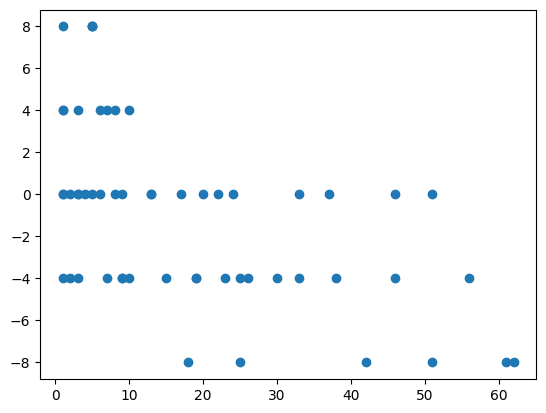

In [242]:
import matplotlib.pyplot as plt

plt.scatter(x, y)

6 node HN, all one weights

In [117]:
pop_size = 1000
rng1 = np.random.default_rng(12345)

W = np.ones((num_nodes, num_nodes))
# W = rng1.integers(0, 2, size=(6, 6)).astype(float)
# W[W==0] = -1
np.fill_diagonal(W, 0)

init_states = rng.integers(0, 2, size=(pop_size, num_nodes))

init_states[init_states==0] = -1
bm = BoltzmannMachine(W, steps, off_act_val=-1)

dist_vis = defaultdict(int)
dist = defaultdict(int)

for state in init_states:
    x_rem = bm.remember(state)
    dist_vis[tuple(x_rem[:2])] += 1
    dist[tuple(x_rem)] += 1


print('>>>> ', len(dist))
for k in sorted(dist.keys()):
    print(k)

>>>>  2
(-1, -1, -1, -1, -1, -1)
(1, 1, 1, 1, 1, 1)


7 node HN, all one weights

In [172]:
pop_size = 1000
rng1 = np.random.default_rng(12345)

W = np.ones((7, 7))
# W = rng1.integers(0, 2, size=(6, 6)).astype(float)
# W[W==0] = -1
np.fill_diagonal(W, 0)

init_states = rng.integers(0, 2, size=(pop_size, 7))

init_states[init_states==0] = -1
bm = BoltzmannMachine(W, steps, off_act_val=-1)

dist_vis = defaultdict(int)
dist = defaultdict(int)
for state in init_states:
    x_rem = bm.remember(state)
    dist_vis[tuple(x_rem[:2])] += 1
    dist[tuple(x_rem)] += 1
print('>>>> ', len(dist))
for k in sorted(dist.keys()):
    print(k, dist[k], bm.calc_energy(np.array(k)))

>>>>  2
(-1, -1, -1, -1, -1, -1, -1) 510 -42.0
(1, 1, 1, 1, 1, 1, 1) 490 -42.0


6 node HN, 2 friends group weights, random init states

In [254]:
pop_size = 1000
rng1 = np.random.default_rng(12345)

W = np.ones((num_nodes, num_nodes))
W[:3, 3:] = -1
W[3:, :3] = -1
np.fill_diagonal(W, 0)

init_states = rng.integers(0, 2, size=(pop_size, num_nodes))
init_states[init_states==0] = -1

# init_states[init_states==0] = -1
bm = BoltzmannMachine(W, steps, off_act_val=-1)

dist_vis = defaultdict(int)
dist = defaultdict(int)
for state in init_states:
    x_rem = bm.remember(state)
    dist_vis[tuple(x_rem[:2])] += 1
    dist[tuple(x_rem)] += 1
print('>>>> ', len(dist))
for k in sorted(dist.keys()):
    print('{:25} | {:^5} | {:^5}'.format(str(k), dist[k], bm.calc_energy(np.array(k))))

>>>>  2
(-1, -1, -1, 1, 1, 1)     |  481  | -30.0
(1, 1, 1, -1, -1, -1)     |  519  | -30.0


6 node HN, 2 friends group weights, same init states

In [233]:
pop_size = 1000
rng1 = np.random.default_rng(12345)

W = np.ones((num_nodes, num_nodes))
W[:3, 3:] = -1
W[3:, :3] = -1
np.fill_diagonal(W, 0)

init_states = np.ones((pop_size, num_nodes), dtype=int)
# init_states[:, 3:] = -1

# init_states[init_states==0] = -1
bm = BoltzmannMachine(W, steps, off_act_val=-1)

dist_vis = defaultdict(int)
dist = defaultdict(int)
for state in init_states:
    x_rem = bm.remember(state)
    dist_vis[tuple(x_rem[:2])] += 1
    dist[tuple(x_rem)] += 1
print('>>>> ', len(dist))
for k in sorted(dist.keys()):
    print('{:25} | {:^5} | {:^5}'.format(str(k), dist[k], bm.calc_energy(np.array(k))))

>>>>  2
(-1, -1, -1, 1, 1, 1)     |  495  | -30.0
(1, 1, 1, -1, -1, -1)     |  505  | -30.0


In [232]:
init_states[:, 3:] = 1
init_states

array([[-1,  1, -1,  1,  1,  1],
       [-1,  1,  1,  1,  1,  1],
       [-1,  1, -1,  1,  1,  1],
       ...,
       [-1,  1,  1,  1,  1,  1],
       [-1,  1, -1,  1,  1,  1],
       [ 1,  1, -1,  1,  1,  1]], dtype=int64)

6 node HN, 3 minimas: 1vs5 // 3vs3 // 2vs4 friends group

RESULT: 
- it does matter whether updates are sequential or random. 
- energy not consistent with the probability, deterministic update rule makes HN stuck at local minima.

In [211]:
pop_size = 10_000
# num_nodes = 7

W1 = np.ones((num_nodes, num_nodes))
W1[1, :] = -1
W1[:, 1] = -1

W2 = np.ones((num_nodes, num_nodes))
W2[:3, 3:] = -1
W2[3:, :3] = -1

# W3 = np.ones((num_nodes, num_nodes))
# W3[:2, 2:] = -1
# W3[2:, :2] = -1

W4 = np.ones((num_nodes, num_nodes))
W4[:, 2:4] = -1
W4[2:4] = -1
W4[2:4, 2:4] = 1

W = W1+W2+W4

np.fill_diagonal(W, 0)

init_states = rng.integers(0, 2, size=(pop_size, num_nodes))
init_states[init_states==0] = -1

bm = BoltzmannMachine(W, steps, off_act_val=-1, update_order='random', stochastic_update=False)

dist_vis = defaultdict(int)
dist = defaultdict(int)
for state in init_states:
    x_rem = bm.remember(state)
    dist_vis[tuple(x_rem[:2])] += 1
    dist[tuple(x_rem)] += 1
print('>>>> no. states found: ', len(dist), f' max stopping step: {max(bm.stopping_step)}')
for k in sorted(dist.keys()):
    print('{:25} | {:^5} | {:^5}'.format(str(k), dist[k], bm.calc_energy(np.array(k))))


# num_nodes = 6
pop_size = 1000

>>>> no. states found:  6  max stopping step: 2
(-1, -1, -1, 1, 1, 1)     | 1375  | -22.0
(-1, -1, 1, 1, -1, -1)    | 2127  | -18.0
(-1, 1, -1, -1, -1, -1)   | 1404  | -22.0
(1, -1, 1, 1, 1, 1)       | 1408  | -22.0
(1, 1, -1, -1, 1, 1)      | 2243  | -18.0
(1, 1, 1, -1, -1, -1)     | 1443  | -22.0


6 node HN, 3 minimas: 1vs5 // 3vs3 // 2vs4 friends group, stochastic update

RESULT: in this hard case, stochastic update makes prob consistent with the energy

In [19]:
pop_size = 10_000
# num_nodes = 7

W1 = np.ones((num_nodes, num_nodes))
W1[1, :] = -1
W1[:, 1] = -1

W2 = np.ones((num_nodes, num_nodes))
W2[:3, 3:] = -1
W2[3:, :3] = -1

# W3 = np.ones((num_nodes, num_nodes))
# W3[:2, 2:] = -1
# W3[2:, :2] = -1

W4 = np.ones((num_nodes, num_nodes))
W4[:, 2:4] = -1
W4[2:4] = -1
W4[2:4, 2:4] = 1

W = W1+W2+W4

np.fill_diagonal(W, 0)

init_states = rng.integers(0, 2, size=(pop_size, num_nodes))
init_states[init_states==0] = -1

bm = BoltzmannMachine(W, steps, off_act_val=-1, update_order='nto1', stochastic_update=True)

dist_vis = defaultdict(int)
dist = defaultdict(int)
for state in init_states:
    x_rem = bm.remember(state)
    dist_vis[tuple(x_rem[:2])] += 1
    dist[tuple(x_rem)] += 1
    
print('>>>> no. states found: ', len(dist), f' max stopping step: {max(bm.stopping_step)}')
for k in sorted(dist.keys()):
    print('{:25} | {:^5} | {:^5}'.format(str(k), dist[k], bm.calc_energy(np.array(k))))


# num_nodes = 6
pop_size = 1000

>>>> no. states found:  17  max stopping step: 26
(-1, -1, -1, 1, -1, -1)   |   3   | -6.0 
(-1, -1, -1, 1, 1, 1)     | 1728  | -22.0
(-1, -1, 1, 1, -1, -1)    | 1309  | -18.0
(-1, -1, 1, 1, 1, 1)      |  123  | -18.0
(-1, 1, -1, -1, -1, -1)   | 1769  | -22.0
(-1, 1, -1, -1, 1, 1)     |   5   | -6.0 
(-1, 1, 1, -1, -1, -1)    |  135  | -18.0
(-1, 1, 1, 1, -1, -1)     |   1   | -6.0 
(1, -1, -1, 1, 1, 1)      |  111  | -18.0
(1, -1, 1, 1, -1, -1)     |   6   | -6.0 
(1, -1, 1, 1, 1, 1)       | 1653  | -22.0
(1, 1, -1, -1, -1, -1)    |  125  | -18.0
(1, 1, -1, -1, -1, 1)     |   2   | -6.0 
(1, 1, -1, -1, 1, -1)     |   1   | -6.0 
(1, 1, -1, -1, 1, 1)      | 1272  | -18.0
(1, 1, 1, -1, -1, -1)     | 1752  | -22.0
(1, 1, 1, -1, 1, 1)       |   5   | -6.0 


In [20]:
W

array([[ 0.,  1.,  1., -1.,  1.,  1.],
       [ 1.,  0., -1., -3., -1., -1.],
       [ 1., -1.,  0.,  1., -1., -1.],
       [-1., -3.,  1.,  0.,  1.,  1.],
       [ 1., -1., -1.,  1.,  0.,  3.],
       [ 1., -1., -1.,  1.,  3.,  0.]])

In [29]:
def test(tup):
    vec = np.array(tup)
    print(W@vec, bm.calc_energy(vec))

In [38]:
test((1, 1, 1, -1, -1, 1))

[ 3.  3. -1. -3.  1. -5.] -2.0


In [22]:
vec = np.array((1, 1, 1, -1, -1, -1) )
W@vec

array([ 1.,  5.,  1., -5., -5., -5.])